In [1]:

# Import stuff
import os,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
try:
    import pickle5 as pickle
except:
    import pickle
import scipy.signal as sig
from copy import deepcopy
import time
from scipy.linalg import svd  

from scipy.fft import fft2
from scipy.spatial.distance import pdist,squareform

upperDir = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(upperDir,'aux-functions'))
sys.path.append(os.path.join(upperDir,'recurrence'))
import quick_visualization as qv
from RecurrenceComputation import RecurrenceComputation


# PSPATH = '/mnt/d/vgmar/model_data/exp906/pstracker/Control/Filtered/th700' #'D:\\vgmar\\model_data\\exp906\\pstracker\\Control\\Filtered\\th700'
# CATPATH= '/mnt/d/vgmar/model_data/exp906/electrode_data/Control' #'D:\\vgmar\\model_data\\exp906\\electrode_data\\Control'
# RECPATH= '/mnt/d/vgmar/model_data/exp906/recurrence/Control' #'D:\\vgmar\\model_data\\exp906\\recurrence\\Control'

PSPATH =  '/users/vgonalve/exec/RPAnalyses/pstracker'
RECPATH = '/users/vgonalve/exec/RPAnalyses/recurrence'


In [2]:
SampleShift = 5
fs = 1000
recComp = RecurrenceComputation()
recComp.SampleShift = 5
recComp.TheilerAFCLNumber = 0.5
recComp.ExpectedAFRecurrenceRate = 2
recComp.MinimumBlockAFCLDuration = 1

Thresholds = np.array([0.05,0.15,0.25])

experimentNames = []
for file in os.listdir(PSPATH):
    if file.startswith('exp906c') and file.endswith('_th700.txt'):
    # if file.startswith('exp909b') and file.endswith('anchor3_th100.txt'):
        experimentNames.append(file.split('_')[0])
experimentNames = np.sort(experimentNames)

experiment = experimentNames[0]
with open(os.path.join(RECPATH,experiment+'_RecurrenceAnalyses.pkl'),'rb') as output:
    DistanceMatrices =  pickle.load(output)
    EstimatedAFCLs =  pickle.load(output)


In [29]:

def RPCalc(DistanceMatrices,EstimatedAFCLs,recComp,threshold):
    RPOut = dict()
    for cat in DistanceMatrices.keys():
        estimatedAFCL = EstimatedAFCLs[cat]
        DM = DistanceMatrices[cat][2500//recComp.SampleShift:,2500//recComp.SampleShift:]
        RP, _, recurrenceThreshold, _ = \
                    recComp.ComputeRecurrencePlot(DM, fs, estimatedAFCL,
                                                  recurrenceThreshold= threshold)
        RP = recComp.ErodeRP(RP,DM)
        RPOut[cat]= RP
    return RPOut
    

def RQAFeats(RPDict,EstimatedAFCLs,recComp,interval='all',BlockDict = None,fs = 1000,timeInterval = None):
    RQA_Out = dict()
    for cat in RPDict.keys():
        estimatedAFCL = EstimatedAFCLs[cat]
        minLineLength = (estimatedAFCL*1000)//recComp.SampleShift
        if timeInterval is None:
            recurrenceMatrix = RPDict[cat]
        else:
            recurrenceMatrix = RPDict[cat][int(timeInterval[0]//recComp.SampleShift):int(timeInterval[1]//recComp.SampleShift),
                                          int(timeInterval[0]//recComp.SampleShift):int(timeInterval[1]//recComp.SampleShift)]
        
        #
        if interval=='all':
            RQA_Out[cat] = recComp.ComputeRQA(recurrenceMatrix,estimatedAFCL,fs,
                                              minDiagonalLine = int(minLineLength),maxLineThickness=2)            
        elif interval=='blocks':
            clusterTimes = BlockDict[cat]['clusterTimes']
            blocksOutput = list()
            for blockId in range(clusterTimes.shape[1]):
                RP = recurrenceMatrix[clusterTimes[:,blockId],:][:,clusterTimes[:,blockId]]
                blocksOutput.append(recComp.ComputeRQA(RP,estimatedAFCL,fs,
                                                       minDiagonalLine = int(minLineLength),maxLineThickness=2)   )
            RQA_Out[cat] = blocksOutput
    return RQA_Out

def GetBlocks(RPDict,recComp,fs = 1000,blockLims = None):
    
    BlockDictOut = dict()
    #
    for cat in RPDict.keys():
        estimatedAFCL = EstimatedAFCLs[cat]
        if blockLims is None:
            recurrenceMatrix = RPDict[cat]
        else:
            recurrenceMatrix = RPDict[cat][int(blockLims[0]/recComp.SampleShift):int(blockLims[1]/recComp.SampleShift),
                                          int(blockLims[0]/recComp.SampleShift):int(blockLims[1]/recComp.SampleShift),]
        
        recurrenceTime = np.linspace(0,recurrenceMatrix.shape[0]*recComp.SampleShift,
                             recurrenceMatrix.shape[0])/fs
        BlockDictOut[cat] = recComp.DetectRecurrentBlocks(recurrenceMatrix, recurrenceTime, estimatedAFCL)
        # Not using right now
        linkingMatrix, clusters, clusterDuration, clusterTimes, blockIndices = \
                    recComp.DetectIntervalClusters(recurrenceMatrix, BlockDictOut[cat], recurrenceTime, estimatedAFCL)
        #
        BlockDictOut[cat]['linkingMatrix'] = linkingMatrix
        BlockDictOut[cat]['clusters'] = clusters
        BlockDictOut[cat]['clusterDuration'] = clusterDuration
        BlockDictOut[cat]['clusterTimes'] = clusterTimes
        BlockDictOut[cat]['blockIndices'] = blockIndices
    return BlockDictOut

In [4]:

#%% Calculate RPs for the three thresholds
recurrenceTime = np.linspace(0,DistanceMatrices['RPV'].shape[0]*recComp.SampleShift,
                             DistanceMatrices['RPV'].shape[0])/1000

ti = time.time()
RP_05 = RPCalc(DistanceMatrices,EstimatedAFCLs,recComp,0.05)
print('Elapsed time: %0.3f s'%(time.time()-ti))

RP_15 = RPCalc(DistanceMatrices,EstimatedAFCLs,recComp,0.15)
RP_25 = RPCalc(DistanceMatrices,EstimatedAFCLs,recComp,0.25)


Elapsed time: 50.624 s


In [22]:
#%% Detect blocks in each of the RPs
recComp.BlockGridAFCLResolution = 1
recComp.MinimumBlockAFCLRecurrenceRate = 0.7

ti = time.time()
BlockDict05= GetBlocks(RP_05,recComp,blockLims = [7000,15000])
print('Elapsed time for 16 x +-27.5 s, resolution %0.1f: %0.3f s'%(recComp.BlockGridAFCLResolution,time.time()-ti))

ti = time.time()
BlockDict15= GetBlocks(RP_15,recComp,blockLims = [7000,15000])
print('Elapsed time for 16 x +-27.5 s, resolution %0.1f: %0.3f s'%(recComp.BlockGridAFCLResolution,time.time()-ti))

ti = time.time()
BlockDict25= GetBlocks(RP_25,recComp,blockLims = [7000,15000])
print('Elapsed time for 16 x +-27.5 s, resolution %0.1f: %0.3f s'%(recComp.BlockGridAFCLResolution,time.time()-ti))

28
56
84
112
140
168
196
224
252
280
308
336
364
392
420
448
476
504
532
560
588
616
644
672
700
728
756
784
812
840
868
896
924
952
980
1008
1036
1064
1092
1120
1148
1176
1204
1232
1260
1288
1316
1344
1372
1400
1428
1456
1484
1512
1540
1568
1596
28
56
84
112
140
168
196
224
252
280
308
336
364
392
420
448
476
504
532
560
588
616
644
672
700
728
756
784
812
840
868
896
924
952
980
1008
1036
1064
1092
1120
1148
1176
1204
1232
1260
1288
1316
1344
1372
1400
1428
1456
1484
1512
1540
1568
1596
28
56
84
112
140
168
196
224
252
280
308
336
364
392
420
448
476
504
532
560
588
616
644
672
700
728
756
784
812
840
868
896
924
952
980
1008
1036
1064
1092
1120
1148
1176
1204
1232
1260
1288
1316
1344
1372
1400
1428
1456
1484
1512
1540
1568
1596
28
56
84
112
140
168
196
224
252
280
308
336
364
392
420
448
476
504
532
560
588
616
644
672
700
728
756
784
812
840
868
896
924
952
980
1008
1036
1064
1092
1120
1148
1176
1204
1232
1260
1288
1316
1344
1372
1400
1428
1456
1484
1512
1540
1568
1596
28
56
84
112

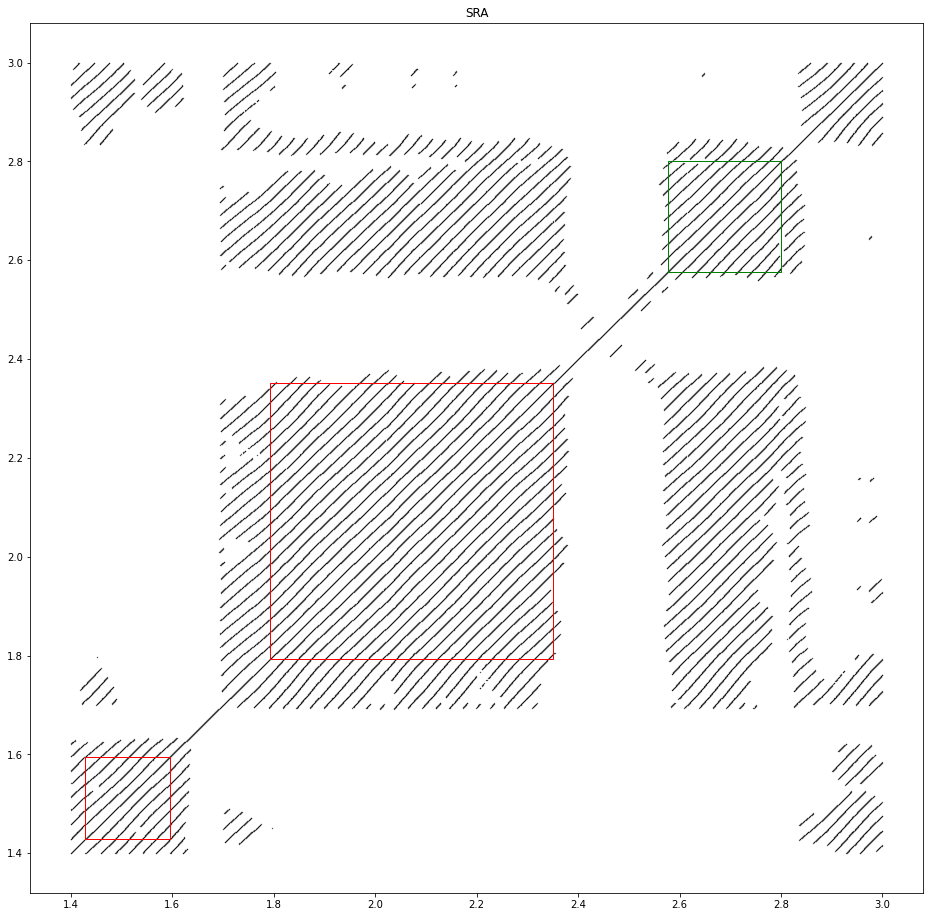

In [27]:
from matplotlib.patches import Rectangle

RPDicts = [RP_05,RP_15,RP_25]
BlockDicts = [BlockDict05]#,BlockDict15,BlockDict25]
dictId = 0
cat = 'SRA'
interval = np.asarray([7000,15000],dtype=int)//recComp.SampleShift


estimatedAFCL = EstimatedAFCLs[cat]
recurrenceMatrix = RPDicts[dictId][cat][interval[0]:interval[1],interval[0]:interval[1]]

plotBlocks = BlockDicts[dictId][cat]
clusterDuration = BlockDicts[dictId][cat]['clusterDuration']
clusterTimes = BlockDicts[dictId][cat]['clusterTimes']
numberOfBlocks = len(clusterDuration)

fig,ax = plt.subplots(1,figsize=(16,16))
xi,yi = np.where(recurrenceMatrix)
timeAxes = np.linspace(interval[0]/1000,(interval[1])/1000,recurrenceMatrix.shape[0])

ax.scatter(timeAxes[xi],timeAxes[yi],c='k',s=0.1)
    # recurrenceMatrix,origin='lower',cmap = 'gray_r',
    #       extent = [recurrenceTime[0],recurrenceTime[-1],recurrenceTime[0],recurrenceTime[-1]])
ax.set_title(cat)
# for block in plotBlocks['intervals_samples']:
#     ax.add_patch(Rectangle((recurrenceTime[block[0]],recurrenceTime[block[0]]), 
#                             recurrenceTime[block[1]-block[0]],recurrenceTime[block[1]-block[0]],
#                            edgecolor='red',
# #                            facecolor='none'))

numberOfBlocks = clusterTimes.shape[1] #plotBlocks['intervals_times'].shape[0]

for blockIndex in range(numberOfBlocks):
    blockPresence = np.append(0,np.append(clusterTimes[:,blockIndex],0))
    blockStarts = np.where(np.diff(blockPresence)>0)[0]
    blockEnds = np.where(np.diff(blockPresence)<0)[0]

    colors = ['r','g','b']
    for ii in range(len(blockStarts)):
        blockInterval = [timeAxes[blockStarts[ii]],timeAxes[blockEnds[ii]]]
        ax.add_patch(Rectangle((blockInterval[0],blockInterval[0]), 
                            np.diff(blockInterval),np.diff(blockInterval),
                            edgecolor=colors[ii],
                            facecolor='none'))


In [31]:
#%% Calculate distances between catheters and the stationary source

# Calculate also the standard deviation of this distance in the meandering cases
print(experiment)
InputDF = pd.read_csv(os.path.join(PSPATH,experiment+'_PSPositionsAndDistances.csv'),index_col=0)
# InputDF = InputDF.loc[InputDF['traj']==372,:]

minDF = [np.min(InputDF.loc[InputDF['t']==t,:],axis=0) for t in np.arange(7000,15000)]#np.unique(InputDF['t'])]
minDF = pd.DataFrame(minDF,columns = InputDF.columns)
minDF[minDF<0] = np.nan
#np.sum(np.diff(minDF[col])==0)/(12000-2500)
test  = [np.nansum(np.diff(minDF[col])) for col in minDF.columns[5:]]


# Calculate distance in blocks

def GetDistanceInBlocks(DistsDF,BlockDict):
    Output= dict()
    for cat in BlockDict.keys():
        clusterTimes = BlockDict[cat]['clusterTimes']
        means = np.zeros(clusterTimes.shape[1])
        stds = np.zeros(clusterTimes.shape[1])
        for blockId in range(clusterTimes.shape[1]):
            inds = np.interp(np.linspace(0,1,len(DistsDF['D'+cat])),
                               np.linspace(0,1,clusterTimes.shape[0]),
                               clusterTimes[:,blockId]).astype(bool)
            dists = DistsDF.loc[inds,['D'+cat]]
            means[blockId] = np.nanmean(dists)
            stds[blockId] = np.nanstd(dists)
            
        Output[cat] = {'mean_dist':np.mean(means),
                       'std_dist':np.mean(stds)}
    return Output

def GetDistanceOutBlocks(DistsDF,BlockDict):
    Output= dict()
    for cat in BlockDict.keys():
        clusterTimes = BlockDict[cat]['clusterTimes'].any(axis=1)

        inds = np.interp(np.linspace(0,1,len(DistsDF['D'+cat])),
                           np.linspace(0,1,clusterTimes.shape[0]),
                           clusterTimes).astype(bool)
        dists = DistsDF.loc[inds,['D'+cat]]            
        Output[cat] = {'mean_dist':np.nanmean(dists),
                       'std_dist':np.nanstd(dists)}
    return Output

DistsIn05 = GetDistanceInBlocks(minDF,BlockDict05)
DistsOut05 = GetDistanceOutBlocks(minDF,BlockDict05)

exp906c04


/opt/python/3.8.5.0/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [30]:
RQA_05 = RQAFeats(RP_05,EstimatedAFCLs,recComp,interval = 'blocks',BlockDict=BlockDict05,timeInterval = [7000,15000])
RQA_15 = RQAFeats(RP_15,EstimatedAFCLs,recComp,interval = 'blocks',BlockDict=BlockDict15,timeInterval = [7000,15000])
RQA_25 = RQAFeats(RP_25,EstimatedAFCLs,recComp,interval = 'blocks',BlockDict=BlockDict25,timeInterval = [7000,15000])

FeatsDicts = []
for Dict in [BlockDict05,BlockDict15,BlockDict25]:
    BlockFeats = dict()
    for cat in Dict.keys():
        clusterTimes = Dict[cat]['clusterTimes']
        BlockFeats[cat] = {'numberOfBlocks':Dict[cat]['intervals_samples'].shape[0],
                             'numberOfPatterns':clusterTimes.shape[1],
                             'percentageWithBlocks':np.sum(clusterTimes.any(axis=1))/clusterTimes.shape[0]}
    FeatsDicts.append(BlockFeats)
        


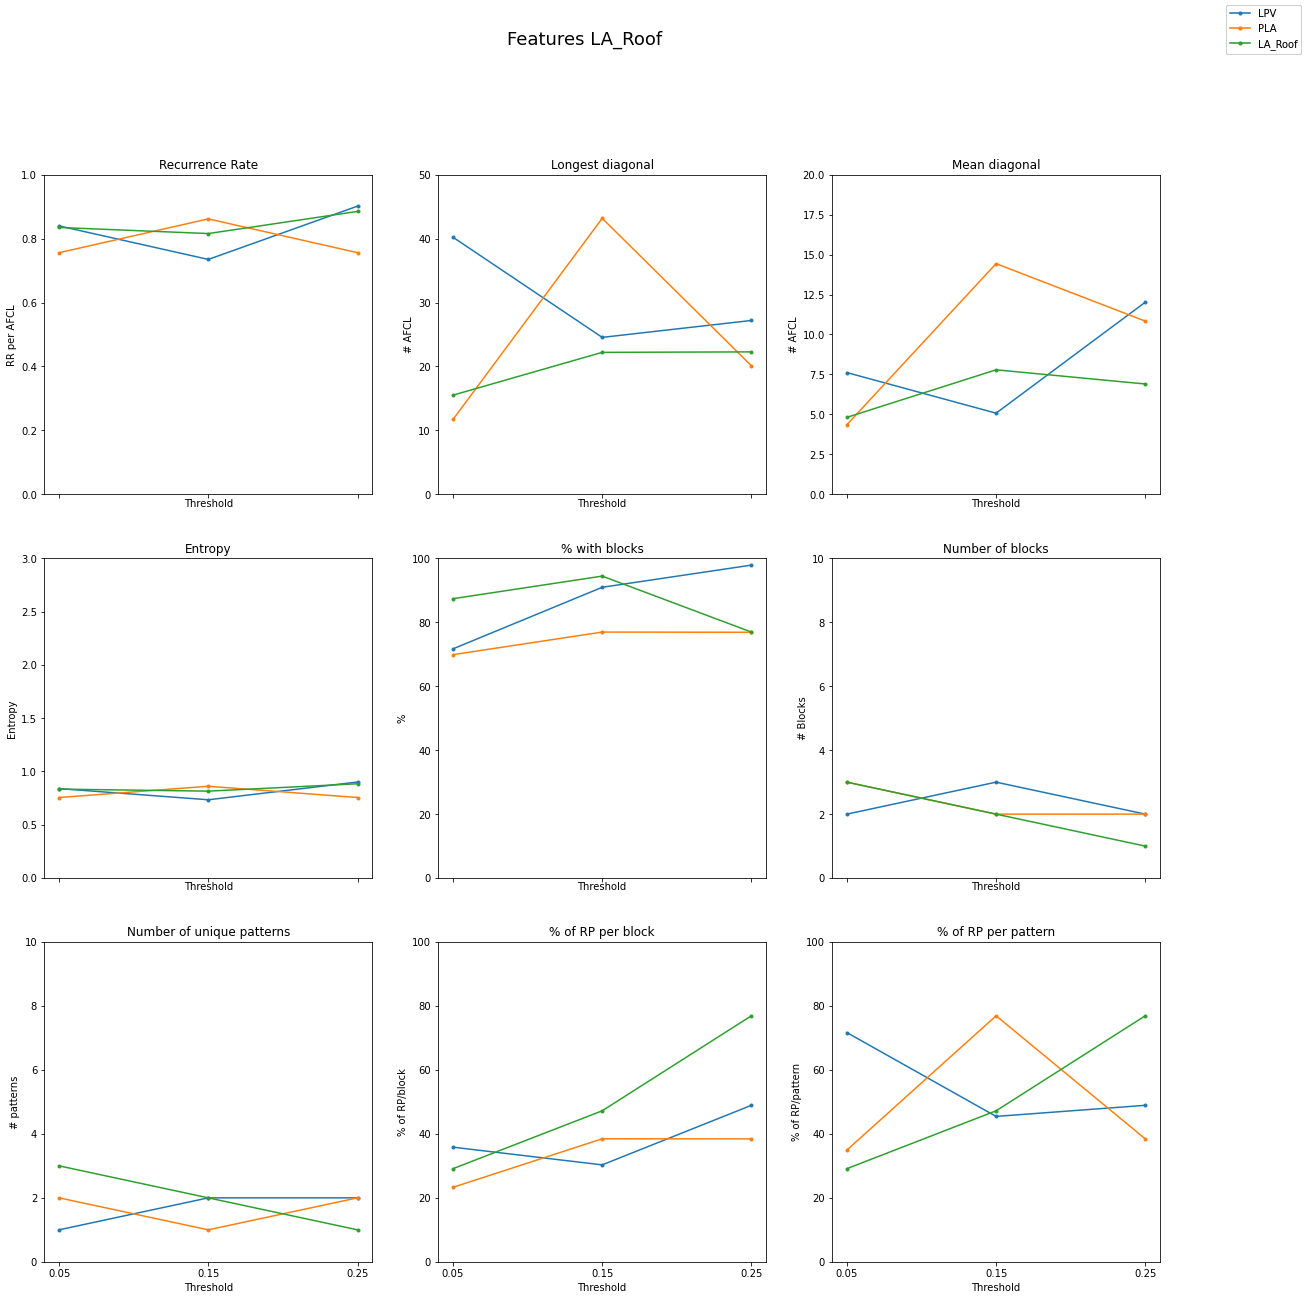

In [49]:
fig,ax = plt.subplots(3,3,sharex = True,figsize=(20,20))

catList=  ['LPV','PLA','LA_Roof'] # minDF.columns[~np.isin(minDF.columns,['DLPV','DLA_Roof','DPLA','DILA_3','t','x','y','z','traj'])] #

for cat in catList:
#     cat = cat[1:]
    
    LMAX = []
    LMEAN = []
    RR = []
    ENT = []
    for Dict in [RQA_05,RQA_15,RQA_25]:
        dictLists= Dict[cat]
        tmpA = list()
        tmpB = list()
        tmpC = list()
        tmpD = list()
        for rqa in dictLists:
            if rqa['determinism']==-1:
                tmpA.append([0])
                tmpB.append([0])
                tmpC.append([0])
                tmpD.append([0])
                continue
            tmpA.append(rqa['longest_diagonal'])
            tmpB.append(rqa['mean_diagonal'])
            tmpC.append(rqa['recurrence_rate'])
            tmpD.append(rqa['entropy'])
        LMAX.append(tmpA)
        LMEAN.append(tmpB)
        RR.append(tmpC)
        ENT.append(tmpC)
        
    LMAX = np.asarray([np.mean(LMAX[ii]) for ii in range(len(LMAX))])
    LMEAN = np.asarray([np.mean(LMEAN[ii]) for ii in range(len(LMEAN))])
    RR = np.asarray([np.mean(RR[ii]) for ii in range(len(RR))])
    ENT = np.asarray([np.mean(ENT[ii]) for ii in range(len(ENT))])
    percentageBlocks = np.asarray([FeatsDicts[ii][cat]['percentageWithBlocks'] for ii in range(3)])
    nBlocks = np.asarray([FeatsDicts[ii][cat]['numberOfBlocks'] for ii in range(3)])
    nPatterns = np.asarray([FeatsDicts[ii][cat]['numberOfPatterns'] for ii in range(3)])
    
    # Recurrence rate per block, over different thresholds
    
    ax[0,0].plot(np.arange(3),RR,'.-')
    ax[0,0].set_xlabel('Threshold')
    ax[0,0].set_ylabel('RR per AFCL')
    ax[0,0].set_xticks([0,1,2])
    ax[0,0].set_xticklabels(['0.05','0.15','0.25'])
    ax[0,0].set_ylim([0,1])
    
    ax[0,0].set_title('Recurrence Rate')
    # Line lenghts per block, over different thresholds
    ax[0,1].plot(np.arange(3),LMAX,'.-')
    ax[0,1].set_xlabel('Threshold')
    ax[0,1].set_ylabel('# AFCL')
    ax[0,1].set_xticks([0,1,2])
    ax[0,1].set_xticklabels(['0.05','0.15','0.25'])
    ax[0,1].set_ylim([0,50])
    ax[0,1].set_title('Longest diagonal')
    
    ax[0,2].plot(np.arange(3),LMEAN,'.-')
    ax[0,2].set_xlabel('Threshold')
    ax[0,2].set_ylabel('# AFCL')
    ax[0,2].set_xticks([0,1,2])
    ax[0,2].set_xticklabels(['0.05','0.15','0.25'])
    ax[0,2].set_ylim([0,20])
    ax[0,2].set_title('Mean diagonal')
    
    # Entropy
    ax[1,0].plot(np.arange(3),ENT,'.-')
    ax[1,0].set_xlabel('Threshold')
    ax[1,0].set_ylabel('Entropy')
    ax[1,0].set_xticks([0,1,2])
    ax[1,0].set_xticklabels(['0.05','0.15','0.25'])
    ax[1,0].set_ylim([0,3])
    ax[1,0].set_title('Entropy')
    
    # Percentage of time with blocks, over thresholds
    ax[1,1].plot(np.arange(3),percentageBlocks*100,'.-')
    ax[1,1].set_xlabel('Threshold')
    ax[1,1].set_ylabel('%')
    ax[1,1].set_xticks([0,1,2])
    ax[1,1].set_xticklabels(['0.05','0.15','0.25'])
    ax[1,1].set_ylim([0,100])
    ax[1,1].set_title('% with blocks')
    
    # Number of blocks, over thresholds
    ax[1,2].plot(np.arange(3),nBlocks,'.-')
    ax[1,2].set_xlabel('Threshold')
    ax[1,2].set_ylabel('# Blocks')
    ax[1,2].set_xticks([0,1,2])
    ax[1,2].set_xticklabels(['0.05','0.15','0.25'])
    ax[1,2].set_ylim([0,10])
    ax[1,2].set_title('Number of blocks')
    
    # Number of patterns, over thresholds
    ax[2,0].plot(np.arange(3),nPatterns,'.-')
    ax[2,0].set_xlabel('Threshold')
    ax[2,0].set_ylabel('# patterns')
    ax[2,0].set_xticks([0,1,2])
    ax[2,0].set_xticklabels(['0.05','0.15','0.25'])
    ax[2,0].set_ylim([0,10])
    ax[2,0].set_title('Number of unique patterns')    
    
    # % of RP per block
    ax[2,1].plot(np.arange(3),percentageBlocks*100/nBlocks,'.-')
    ax[2,1].set_xlabel('Threshold')
    ax[2,1].set_ylabel('% of RP/block')
    ax[2,1].set_xticks([0,1,2])
    ax[2,1].set_xticklabels(['0.05','0.15','0.25'])
    ax[2,1].set_ylim([0,100])
    ax[2,1].set_title('% of RP per block')    
    
    # % of RP per block
    ax[2,2].plot(np.arange(3),percentageBlocks*100/nPatterns,'.-')
    ax[2,2].set_xlabel('Threshold')
    ax[2,2].set_ylabel('% of RP/pattern')
    ax[2,2].set_xticks([0,1,2])
    ax[2,2].set_xticklabels(['0.05','0.15','0.25'])
    ax[2,2].set_ylim([0,100])
    ax[2,2].set_title('% of RP per pattern')       
    
    fig.suptitle('Features %s'%cat,fontsize=18)
    fig.legend(catList)

In [40]:
DistsIn05 

{'RPV': {'mean_dist': 23.740039752757234, 'std_dist': 4.480563707367089},
 'LPV': {'mean_dist': 12.246603970741901, 'std_dist': 8.779218606530147},
 'PLA': {'mean_dist': 22.983004199597744, 'std_dist': 4.090817601405552},
 'ILA_1': {'mean_dist': 30.06565101617714, 'std_dist': 6.614392651186197},
 'ILA_2': {'mean_dist': 21.01867173640838, 'std_dist': 8.086610429781171},
 'ILA_3': {'mean_dist': 19.758630594087595, 'std_dist': 5.652263795643017},
 'ALA': {'mean_dist': 27.515466983938133, 'std_dist': 5.667720042566914},
 'LA_Roof': {'mean_dist': 16.094005281961348, 'std_dist': 4.573331356181656},
 'LA_AS': {'mean_dist': 15.086568555485902, 'std_dist': 6.978157422635726},
 'LAA': {'mean_dist': 22.24557391326421, 'std_dist': 6.196709692303183},
 'SRA': {'mean_dist': 26.08048505152762, 'std_dist': 7.623489760770688},
 'IRA': {'mean_dist': 31.68025097325148, 'std_dist': 6.058616562462105},
 'RAA': {'mean_dist': 23.322806535768226, 'std_dist': 11.931034844173892},
 'PECT': {'mean_dist': 39.9346